# Denoising autoencoder for Noisy Circles
Neural networks dislike noisy data; they can somewhat overcome it with a large number of training samples but bad data is best kept out of the mix. One approach to accomplish that is to use a denoising auto-encoder. This should speed up our circle detection.

In [1]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore') 
from pathlib import Path

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
from keras.models import load_model
from PIL import Image
import random
from copy import deepcopy
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras import Model
from keras.callbacks import TensorBoard, ModelCheckpoint
import wandb
from wandb.keras import WandbCallback
wandb.init(project="ml-you-can-use")

plt.style.use('classic')

Using TensorFlow backend.


wandb: Wandb version 0.8.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Some canned functions for generating noisy circles

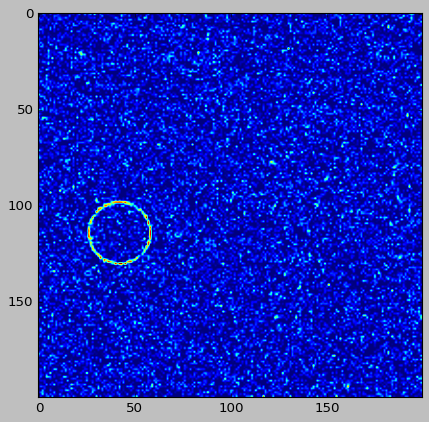

In [41]:
def draw_circle(img, row, col, rad):
    """Draw a circle into a matrix."""
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    """Generate a random circle for an image, and add noise."""
    img = np.zeros((size, size), dtype=np.float)
    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)
    # Add noise
#     img += noise * np.random.rand(*img.shape)
    img = img + noise * np.random.normal(loc=0.0, scale=1.0, size=img.shape) 
    img = np.clip(img, 0., 1.)
    return (row, col, rad), img

def show_image(an_image):
    # convert values to 0 - 255 int8 format
    formatted = (an_image * 255 / np.max(an_image)).astype('uint8')
    img = Image.fromarray(formatted)
    plt.style.use('classic')
    imshow(np.asarray(img))

params, an_image = noisy_circle(200, 50, 0.2)    
show_image(an_image)

## Our helper functions adjusted to help generate our training data

In [42]:
def draw_circle(img, row, col, rad):
    """Draw a circle into a matrix."""
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def make_random_circle(size, radius):
    """Generate a random circle in an image."""
    img = np.zeros((size, size), dtype=np.float)
    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(9, max(10, radius))
    draw_circle(img, row, col, rad)
    return (img, row, col, rad)

def add_noise(img, noise):
    # Add noise
#     img += noise * np.random.rand(*img.shape)
    img = img + noise * np.random.normal(loc=0.0, scale=1.0, size=img.shape) 
    img = np.clip(img, 0., 1.)
    return img

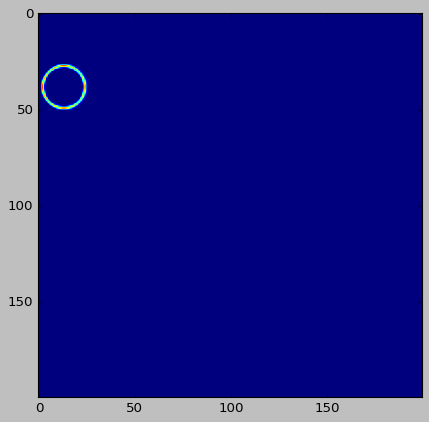

In [43]:
ran_radius = random.randint(0, 50)
test_image, row, col, rad = make_random_circle(200, ran_radius)
show_image(test_image)

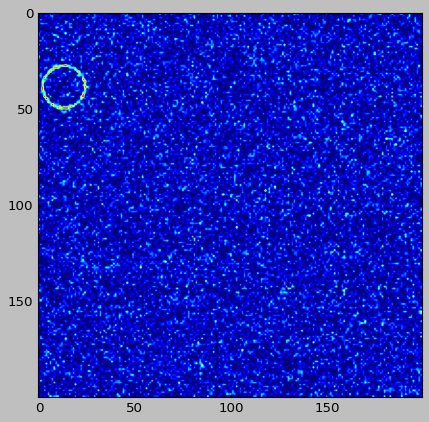

In [44]:
test_image_noisy = add_noise(deepcopy(test_image), 0.2)
show_image(test_image_noisy)

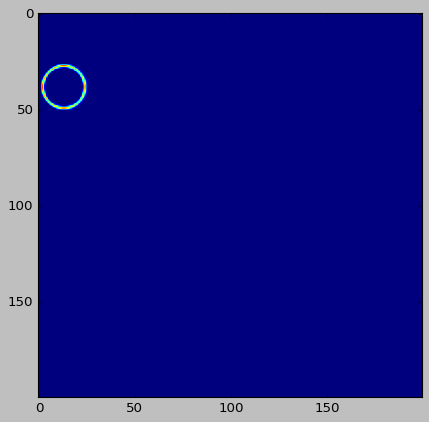

In [45]:
 show_image(test_image)

In [46]:
test_image.shape

(200, 200)

In [47]:
X_train = []
for i in range(8000):    
    ran_radius = random.randint(0, 50)
    test_image, row, col, rad = make_random_circle(200, ran_radius)
    X_train.append(test_image)
X_test = []
for i in range(2000):    
    ran_radius = random.randint(0, 50)
    test_image, row, col, rad = make_random_circle(200, ran_radius)
    X_test.append(test_image)

In [48]:
X_train = np.array(X_train)
X_train.shape
X_train = np.reshape(X_train, (len(X_train), 200, 200, 1)) 

In [49]:
X_test = np.array(X_test)
X_test.shape
X_test = np.reshape(X_test, (len(X_test), 200, 200, 1)) 
X_test.shape

(2000, 200, 200, 1)

In [50]:
noise_factor = 0.2 
# X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
# X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = X_train + noise_factor * np.random.rand( * X_train[0].shape) 
X_test_noisy = X_test + noise_factor * np.random.rand( * X_train[0].shape) 


X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [51]:
input_img = Input(shape=(200, 200, 1), name='InputLayer') 
# adapt this if using `channels_first` image data format
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_Layer_1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_Layer_1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_Layer_2')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_Layer_2')(x)
# at this point the representation is (7, 7, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_Layer_3')(encoded)
x = UpSampling2D((2, 2), name='UpSampling2D_Layer_1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_Layer_4')(x)
x = UpSampling2D((2, 2), name='UpSampling2D_Layer_2')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Conv2D_Layer_5')(x)
autoencoder = Model(input_img, decoded, name='NoisyCircle_DenoisingAutoencoder')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "NoisyCircle_DenoisingAutoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      (None, 200, 200, 1)       0         
_________________________________________________________________
Conv2D_Layer_1 (Conv2D)      (None, 200, 200, 32)      320       
_________________________________________________________________
MaxPooling2D_Layer_1 (MaxPoo (None, 100, 100, 32)      0         
_________________________________________________________________
Conv2D_Layer_2 (Conv2D)      (None, 100, 100, 32)      9248      
_________________________________________________________________
MaxPooling2D_Layer_2 (MaxPoo (None, 50, 50, 32)        0         
_________________________________________________________________
Conv2D_Layer_3 (Conv2D)      (None, 50, 50, 32)        9248      
_________________________________________________________________
UpSampling2D_Layer_1 (UpSamp (None

In [52]:
history = autoencoder.fit(X_train_noisy, X_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test),
                callbacks=[WandbCallback(), 
                           TensorBoard(log_dir='tmptb',
                                       histogram_freq=0, write_graph=False)])

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
 256/8000 [..............................] - ETA: 19s - loss: 0.7040

wandb: Wandb version 0.8.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


8000/8000 [==============================] - 11s 1ms/step - loss: 0.1948 - val_loss: 0.0274
Epoch 2/30
8000/8000 [==============================] - 9s 1ms/step - loss: 0.0268 - val_loss: 0.0259
Epoch 3/30
8000/8000 [==============================] - 9s 1ms/step - loss: 0.0252 - val_loss: 0.0242
Epoch 4/30
8000/8000 [==============================] - 9s 1ms/step - loss: 0.0232 - val_loss: 0.0218
Epoch 5/30
8000/8000 [==============================] - 9s 1ms/step - loss: 0.0204 - val_loss: 0.0184
Epoch 6/30
8000/8000 [==============================] - 8s 1ms/step - loss: 0.0160 - val_loss: 0.0119
Epoch 7/30
8000/8000 [==============================] - 8s 1ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 8/30
8000/8000 [==============================] - 8s 1ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 9/30
8000/8000 [==============================] - 9s 1ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 10/30
8000/8000 [==============================] - 8s 1ms/step - loss: 0.0052 - val_lo

In [53]:
autoencoder.save('noisy.circle.denoiser.hdf5')

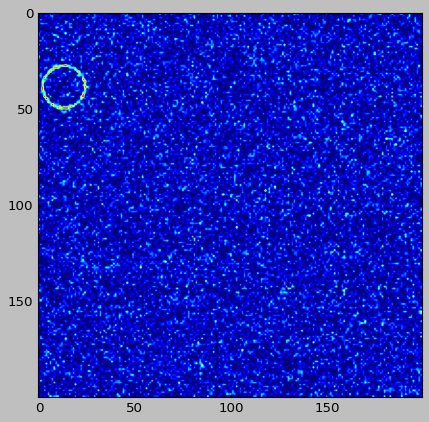

In [54]:
show_image(test_image_noisy)

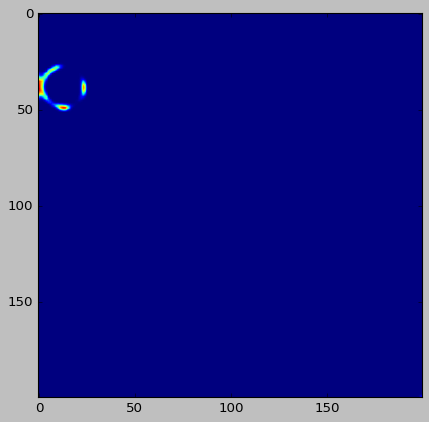

In [55]:
test_img =test_image_noisy.reshape(1, 200,200, 1)
# test_img = np.clip(test_img, 0., 1.)
show_image(autoencoder.predict(test_img).reshape(200, 200))

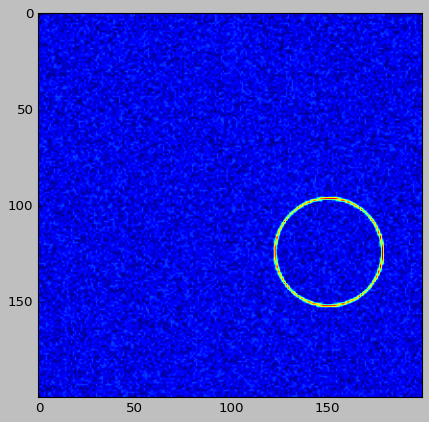

In [56]:
show_image(X_train_noisy[0].reshape(200,200))

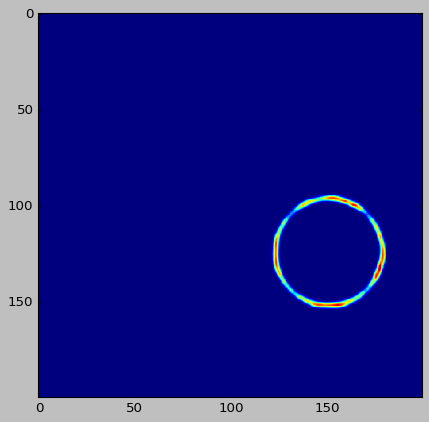

In [57]:
show_image(autoencoder.predict(X_train_noisy[0].reshape(1,200,200,1)).reshape(200, 200))